In [1]:
import os
import numpy as np
import pandas as pd

from biom import Table,load_table
from skbio import OrdinationResults
from skbio import DistanceMatrix
from skbio.stats.distance import permanova

import qiime2 as q2
from qiime2.plugins.deicode.actions import rpca
from qiime2.plugins.songbird.actions import multinomial 
from qiime2.plugins.songbird.actions import summarize_paired 
from qiime2.plugins.feature_table.actions import rarefy
from qiime2.plugins.diversity.actions import alpha_phylogenetic
from qiime2.plugins.diversity.actions import beta_phylogenetic
from qiime2.plugins.feature_table.actions import rarefy

from scipy.stats import sem
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from math import log

import plotnine as pn

o="observation"
s="sample"

In [3]:
from zipfile import ZipFile
def get_q2(file):
    """Given path to modela_fit.qzv, returns q2 score"""
    with ZipFile(file, 'r') as z:
        index_file=[x for x in z.namelist() if "index.html" in x][0]
        with z.open(index_file) as f:
            q2=f.readlines()[3].split()[-1].decode("utf-8") .replace("</p>",'')
            return(q2)

# Import data

In [8]:
 %%script bash 
echo '
#!/bin/bash -l
#PBS -m ae
#PBS -M swandro@ucsd.edu
#PBS -S /bin/bash
#PBS -e /projects/cmi_proj/seed_grants/T1D_JaneKim/logs
#PBS -o //projects/cmi_proj/seed_grants/T1D_JaneKim//logs
#PBS -l walltime=6:00:00
#PBS -l nodes=1:ppn=8
#PBS -l mem=64gb
#PBS -N gotus_t1d

python /home/swandro/scripts/calculate_coverages6.py -i /projects/cmi_proj/seed_grants/T1D_JaneKim/shogun_function/tax_profiles \
                                        -o /projects/cmi_proj/seed_grants/T1D_JaneKim/shotgun/t1d_gotu



' 


#!/bin/bash -l
#PBS -m ae
#PBS -M swandro@ucsd.edu
#PBS -S /bin/bash
#PBS -e /projects/cmi_proj/seed_grants/T1D_JaneKim/logs
#PBS -o //projects/cmi_proj/seed_grants/T1D_JaneKim//logs
#PBS -l walltime=6:00:00
#PBS -l nodes=1:ppn=8
#PBS -l mem=64gb
#PBS -N gotus_t1d

python /home/swandro/scripts/calculate_coverages6.py -i /projects/cmi_proj/seed_grants/T1D_JaneKim/shogun_function/tax_profiles \
                                       -o /projects/cmi_proj/seed_grants/T1D_JaneKim/shotgun/t1d_gotu






# Import and format data

In [2]:
md = pd.read_csv("../data/metadata/11129_20200129-223118.txt", sep='\t', index_col=0)
md["analysis_t1d"] = md.analysis_t1d.replace({"H":"Healthy","T1D":"Type 1 Diabetes"})
md["analysis_weight_group"] = md.analysis_weight_group.replace({"O":"Overweight","N":"Normal weight"})


df = pd.read_csv("../data/metagenomics/t1d_gotu.norm.tsv", sep='\t', index_col=0)
bt = Table(data=df.to_numpy(), observation_ids=list(df.index), sample_ids=list(df.columns), type="OTU table")
#Rename samples
rename_dict = {x:x.replace("_bt2_wol_alignment","") for x in bt.ids()}
bt.update_ids(rename_dict)

#Check just within normal weight
#normal_weight_samples = set( md.loc[md.analysis_weight_group=="Normal weight"].index ) & set( bt.ids() )
#bt.filter(normal_weight_samples, axis="sample")

#Import gotu metadata
feature_metadata = pd.read_csv("/home/swandro/databases/g2lineage.txt", sep='\t', index_col=0, header=None, names=["taxon"])
gotu2genus_dict = {name:value.values[0].split("; s__")[0] for name,value in feature_metadata.iterrows()}
#Add genus metadata
bt.add_metadata({x:{"genus":gotu2genus_dict[x]} for x in bt.ids("observation")}, axis="observation")
#Collapse to genus
bin_f = lambda id_, x: x['genus']
bt_genus = bt.collapse(bin_f, norm=False, axis="observation")

def b2q(bt):
    return(q2.Artifact.import_data('FeatureTable[Frequency]',bt))

#Import to qiime2
qza = b2q(bt_genus)
qza_gotu = b2q(bt)

#Import tree
tree_q2=q2.Artifact.load("/projects/wol/20170307/release/databases/qiime2/phylogeny.qza")

#Import metadata and make mbi numeric
data_samples = set(bt.ids())
md = md.query('index in @data_samples')
md["host_body_mass_index_z_score"] = md.host_body_mass_index_z_score.astype("float64")

qza_md = q2.Metadata(md)

# Alpha diversity

In [11]:
md_cols= ["analysis_t1d", "analysis_weight_group","analysis_disease_stage_group","host_body_mass_index_z_score"]

qza_rare = rarefy(qza_gotu, 2000).rarefied_table
alpha = alpha_phylogenetic(table=qza_rare, phylogeny=tree_q2, metric="faith_pd").alpha_diversity\
    .view(pd.Series)\
    .to_frame()\
    .join(md.loc[:,md_cols])


In [62]:
def make_boxplot(df, var_col, value_col, axis_label):
    grps = set(df[var_col])
    anova_values = [list(df.loc[df[var_col] == x][value_col]) for x in grps]
    print(f_oneway(*anova_values))
    #PLOT
    plot_dat = df.copy()

    plot_dat["x_axis"] = pd.Categorical(df[var_col],
                                        categories=["NH",
                                                    "OH",
                                                    "NT1D",
                                                    "OT1D"])
    p = (pn.ggplot(data = plot_dat) +
    pn.geom_boxplot( pn.aes( x="x_axis", y=value_col), outlier_alpha=0) +
     pn.geom_jitter( pn.aes(x="x_axis", y=value_col), size=1, width=.1) +
     pn.labs( x="", y=axis_label) +
     pn.theme_classic(base_size=14) +
     pn.theme(
     axis_text = pn.element_text(color="black"))
     
    )
    return(p)

F_onewayResult(statistic=1.5279679511878748, pvalue=0.21134803071953898)


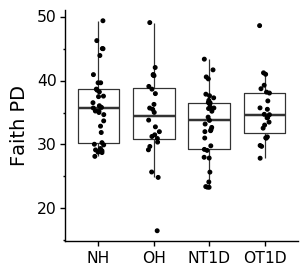

<ggplot: (-9223363294047277778)>

In [63]:
make_boxplot(alpha, "analysis_disease_stage_group", "faith_pd","Faith PD")

### Run deicode

In [38]:
n_components = 4

rpca_biplot, rpca_dm = rpca(qza, n_components=n_components)

### Beta div

In [31]:
rare_depth=200000

qza_rare = rarefy(qza_gotu, rare_depth).rarefied_table

In [39]:
beta_dict = {}
metrics = ["weighted_unifrac", "unweighted_unifrac"]
beta_dict["rpca"] = rpca_dm.view(DistanceMatrix)

for metric in metrics:
    beta_dict[metric] = beta_phylogenetic(table = qza_rare, phylogeny=tree_q2, metric=metric).distance_matrix.view(DistanceMatrix)

## Biplot

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 3 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


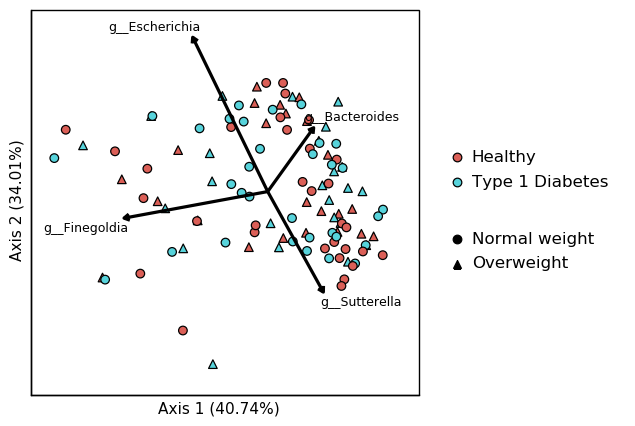

<ggplot: (8742807404527)>

In [25]:
pn.options.figure_size = (5,5)

arow_scale = 1
y_label_offset=.015
x_label_offset=.04
#number_features = 4
taxa_to_keep = ["g__Escherichia","g__Sutterella","g__Finegoldia","g__Bacteroides"]
#taxa_to_keep=[]

ordination = rpca_biplot.view(OrdinationResults)
plot_dat = ordination.samples
plot_dat.columns=["axis" + str(i) for i in range(n_components)]
plot_dat = plot_dat.merge(md, right_index=True, left_index=True)


feature_vectors = ordination.features
feature_vectors["tot_variation"] = feature_vectors.apply(axis=1, func=lambda row: sum([abs(float(y)) for y in row[:2]]))
feature_vectors = feature_vectors.sort_values("tot_variation", ascending=False)
feature_vectors.columns=["axis" + str(i) for i in range(n_components)] + ["tot_variation"]
feature_vectors["short_name"] = ["g__" + x.split("; g__")[1] for x in feature_vectors.index]
#Add offset to text
feature_vectors["axis1"] = [x * arow_scale for x in feature_vectors["axis1"]]
feature_vectors["axis2"] = [x * arow_scale for x in feature_vectors["axis2"]]
feature_vectors["text_axis1"] = [x + x_label_offset if x > 0 else x - x_label_offset for x in feature_vectors["axis1"]]
feature_vectors["text_axis2"] = [x + y_label_offset if x > 0 else x - y_label_offset for x in feature_vectors["axis2"]]
if taxa_to_keep:
    feature_vectors = feature_vectors.loc[[x in taxa_to_keep for x in feature_vectors.short_name]]
else:
    feature_vectors = feature_vectors.iloc[:number_features, :]
#Get variance
variance = ordination.proportion_explained

p = (pn.ggplot(data = plot_dat) +
    pn.geom_point( pn.aes(x ="axis1", y="axis2", fill= "analysis_t1d", shape="analysis_weight_group"),stroke=.5, size=3) +
    pn.geom_segment( data=feature_vectors, mapping=pn.aes(x=0, y=0, xend ="axis1", yend="axis2"), arrow=pn.geoms.arrow(length=.08, type="closed"), size=1.3) +
    pn.geom_text( data=feature_vectors, mapping=pn.aes(x="text_axis1", y="text_axis2", label="short_name"), size=9) +
     #pn.scale_shape_manual(name=" ",values=["^","o"], labels=["Normal weight","Overweight"]) +
     #pn.scale_fill_manual(name=" ", labels=["Qa-1-/-","WT"],values=["lightgrey","white"]) +
     pn.scale_x_continuous(limits=[-.23,.14]) +
     #pn.guides() +
    pn.labs(x="Axis 1 ({}%)".format(round(variance[0]*100,2)),
            y="Axis 2 ({}%)".format(round(variance[1]*100,2)),
           shape='',
           fill="") +
     pn.theme_classic() +
     pn.theme(
         axis_text = pn.element_blank(),
         panel_background = pn.element_rect(size=1, color="black", fill=None),
         axis_ticks = pn.element_blank(),
         legend_text = pn.element_text(size=12)
     )
    )

p

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 3 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


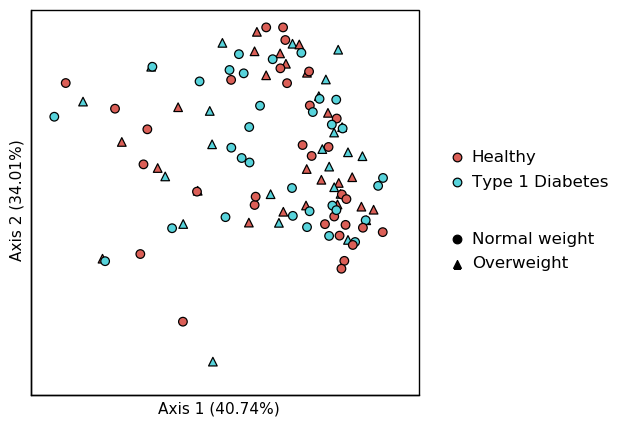

<ggplot: (-9223363294047374823)>

In [26]:
pn.options.figure_size = (5,5)

arow_scale = 1
y_label_offset=.015
x_label_offset=.04
#number_features = 4
taxa_to_keep = ["g__Escherichia","g__Sutterella","g__Finegoldia","g__Bacteroides"]
#taxa_to_keep=[]

ordination = rpca_biplot.view(OrdinationResults)
plot_dat = ordination.samples
plot_dat.columns=["axis" + str(i) for i in range(n_components)]
plot_dat = plot_dat.merge(md, right_index=True, left_index=True)


feature_vectors = ordination.features
feature_vectors["tot_variation"] = feature_vectors.apply(axis=1, func=lambda row: sum([abs(float(y)) for y in row[:2]]))
feature_vectors = feature_vectors.sort_values("tot_variation", ascending=False)
feature_vectors.columns=["axis" + str(i) for i in range(n_components)] + ["tot_variation"]
feature_vectors["short_name"] = ["g__" + x.split("; g__")[1] for x in feature_vectors.index]
#Add offset to text
feature_vectors["axis1"] = [x * arow_scale for x in feature_vectors["axis1"]]
feature_vectors["axis2"] = [x * arow_scale for x in feature_vectors["axis2"]]
feature_vectors["text_axis1"] = [x + x_label_offset if x > 0 else x - x_label_offset for x in feature_vectors["axis1"]]
feature_vectors["text_axis2"] = [x + y_label_offset if x > 0 else x - y_label_offset for x in feature_vectors["axis2"]]
if taxa_to_keep:
    feature_vectors = feature_vectors.loc[[x in taxa_to_keep for x in feature_vectors.short_name]]
else:
    feature_vectors = feature_vectors.iloc[:number_features, :]
#Get variance
variance = ordination.proportion_explained

p = (pn.ggplot(data = plot_dat) +
    pn.geom_point( pn.aes(x ="axis1", y="axis2", fill= "analysis_t1d", shape="analysis_weight_group"),stroke=.5, size=3) +
    
     pn.scale_x_continuous(limits=[-.23,.14]) +
     #pn.guides() +
    pn.labs(x="Axis 1 ({}%)".format(round(variance[0]*100,2)),
            y="Axis 2 ({}%)".format(round(variance[1]*100,2)),
           shape='',
           fill="") +
     pn.theme_classic() +
     pn.theme(
         axis_text = pn.element_blank(),
         panel_background = pn.element_rect(size=1, color="black", fill=None),
         axis_ticks = pn.element_blank(),
         legend_text = pn.element_text(size=12)
     )
    )

p

## Permanova

In [43]:
perm_list = []

for metric,dm in beta_dict.items():
    for factor in ["analysis_t1d","analysis_weight_group","analysis_disease_stage_group"]:
        perm =  permanova(dm, grouping=md, column=factor)
        perm_list.append([metric,factor, perm["sample size"], perm["test statistic"], perm["p-value"]])

permanova_summary_df= pd.DataFrame(perm_list, columns=["distance_metric","Variable","n","pseudo_F","p_value"])
permanova_summary_df

,distance_metric,Variable,n,pseudo_F,p_value
0,rpca,analysis_t1d,114,0.182659,0.918
1,rpca,analysis_weight_group,114,1.875471,0.108
2,rpca,analysis_disease_stage_group,114,0.821896,0.607
3,weighted_unifrac,analysis_t1d,111,1.149555,0.297
4,weighted_unifrac,analysis_weight_group,111,0.995652,0.391
5,weighted_unifrac,analysis_disease_stage_group,111,0.929014,0.495
6,unweighted_unifrac,analysis_t1d,111,1.128080,0.250
7,unweighted_unifrac,analysis_weight_group,111,1.010845,0.386
8,unweighted_unifrac,analysis_disease_stage_group,111,1.059500,0.290


## Distances

In [85]:
from scipy.stats import sem

In [88]:
dm_df = rpca_dm.view(DistanceMatrix).to_data_frame()
dm_df = dm_df.reset_index().melt(id_vars="index")
dm_df.columns=["sample1","sample2","value"]
dm_df = dm_df.merge(md.loc[:,["analysis_disease_stage_group"]], left_on="sample1", right_index=True)
dm_df.columns=["sample1","sample2","value", "grp1"]
dm_df = dm_df.merge(md.loc[:,["analysis_disease_stage_group"]], left_on="sample2", right_index=True)
dm_df.columns=["sample1","sample2","value", "grp1", "grp2"]
dm_df = dm_df.query('value!=0')

dm_df = dm_df.query('grp1=="NH"')

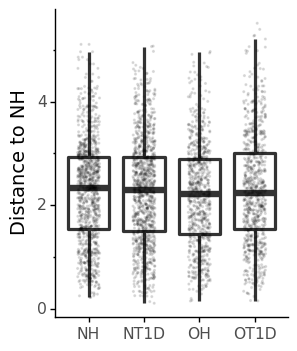

<ggplot: (8778247435454)>

In [100]:
pn.options.figure_size = (3,4)

p= (pn.ggplot( data= dm_df) +
   pn.geom_boxplot( pn.aes(x="grp2", y="value"), outlier_alpha=0, size=1.3) +
    pn.geom_jitter( pn.aes(x="grp2", y="value"), width=.2, alpha=.1, size=.3) +
    pn.labs( x='', y="Distance to NH") +
    pn.theme_classic(base_size=14) 
    
   )
p

In [103]:
grps = set(dm_df.grp2)
anova_values = [list(dm_df.query('grp2==@x').value) for x in grps]
f_oneway(*anova_values)

F_onewayResult(statistic=1.3383237693255654, pvalue=0.26002642978489804)

# Differential abundance

In [185]:
!rm -r songbird

100%|██████████| 21000/21000 [00:25<00:00, 812.66it/s]


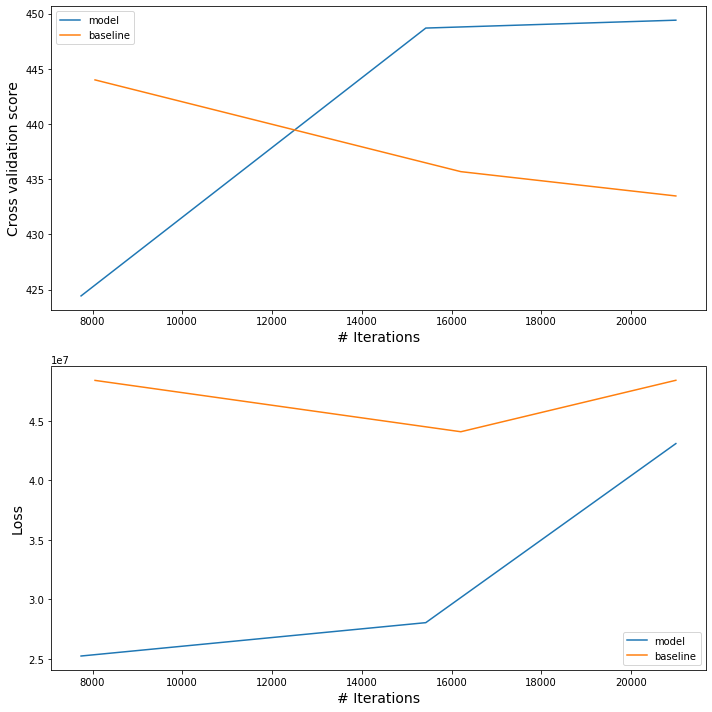

In [32]:
!mkdir -p songbird2

#Set up dictionaries
songbird_dict = {}

#Run/Import Songbird
folder = "songbird2/"
formula = "analysis_t1d + host_body_mass_index_z_score"

tmp_qza=b2q(bt_genus)
#Calculate Songbird
(temp_differentials,
 temp_regression_stats,
 temp_regression_biplot) = multinomial(table=tmp_qza,
                                       metadata=qza_md,
                                       formula=formula,
                                       min_sample_count=0,
                                      min_feature_count=0)

(null_differentials,
 null_regression_stats,
 null_regression_biplot) = multinomial(table=tmp_qza,
                                       metadata=qza_md,
                                       formula="1",
                                      min_sample_count=0,
                                      min_feature_count=0)

#Evaluate model fit
tmp_model_fit = summarize_paired(regression_stats = temp_regression_stats,
                            baseline_stats = null_regression_stats).visualization

#Add outputs to master dictionary
songbird_dict["differentials"] = temp_differentials
songbird_dict["regression_stats"] = temp_regression_stats
songbird_dict["regression_biplot"] = temp_regression_biplot
songbird_dict["model_fit"] = tmp_model_fit

#Save outputs
temp_differentials.save(folder + "/differentials.qza")
temp_regression_stats.save(folder + "/regression_stats.qza")
temp_regression_biplot.save(folder + "/regression_biplot.qza")
tmp_model_fit.save(folder + "/model_fit.qzv")

#Save q2 value
q2_value = get_q2("{}/model_fit.qzv".format(folder))

#else:
#    songbird_dict["differentials"] = q2.Artifact.load(folder + "/differentials.qza")
#    songbird_dict["regression_stats"] = q2.Artifact.load(folder + "/regression_stats.qza")
#    songbird_dict["regression_biplot"] = q2.Artifact.load(folder + "/regression_biplot.qza")

In [40]:
folder = "songbird2/"
songbird_dict["differentials"] = q2.Artifact.load(folder + "/differentials.qza")
songbird_dict["regression_stats"] = q2.Artifact.load(folder + "/regression_stats.qza")
songbird_dict["regression_biplot"] = q2.Artifact.load(folder + "/regression_biplot.qza")
q2_value = get_q2("{}/model_fit.qzv".format(folder))


In [41]:
q2_value

'-0.005848'

In [34]:
diff_df = temp_differentials.view(pd.DataFrame)
#diff_df.sort_values('analysis_t1d').tail(20)
diff_df

,Intercept,analysis_t1d[T.Type 1 Diabetes],host_body_mass_index_z_score
featureid,,,
k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Prevotellaceae; g__Prevotella,9.818615,1.472738,0.194212
k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides,12.690142,0.776289,0.246031
k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Porphyromonadaceae; g__Parabacteroides,10.020802,0.860646,0.124104
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Eubacteriaceae; g__Eubacterium,9.701094,0.922070,0.236634
k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Prevotellaceae; g__Paraprevotella,7.374559,1.317803,0.301096
...,...,...,...
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Intrasporangiaceae; g__Monashia,-1.635158,-0.417487,-0.237024
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Micrococcaceae; g__Renibacterium,-1.632268,-0.390208,-0.232108
k__Bacteria; p__Firmicutes; c__Clostridia; o__Thermoanaerobacterales; f__Thermoanaerobacterales Family III. Incertae Sedis; g__Thermosediminibacter,-1.629755,-0.429238,-0.211668


In [20]:
1+1

2

In [186]:
!mkdir -p songbird

#Set up dictionaries
factor_dict = {"t1d":"analysis_t1d", "weight":"analysis_weight_group", "null":"1" }
songbird_dict = {"t1d":{},"weight":{},"null":{}}

#Run/Import Songbird
for factor in ["t1d","weight","null"]:
    folder = "songbird/" +  factor
    if not os.path.exists(folder):
        !mkdir -p $folder
        #Calculate Songbird
        (temp_differentials,
         temp_regression_stats,
         temp_regression_biplot) = multinomial(table=b2q(bt_genus),
                                               metadata=qza_md,
                                               formula=factor_dict[factor])
        #Add outputs to master dictionary
        songbird_dict[factor]["differentials"] = temp_differentials
        songbird_dict[factor]["regression_stats"] = temp_regression_stats
        songbird_dict[factor]["regression_biplot"] = temp_regression_biplot
        #Save outputs
        temp_differentials.save(folder + "/differentials.qza")
        temp_regression_stats.save(folder + "/regression_stats.qza")
        temp_regression_biplot.save(folder + "/regression_biplot.qza")
    else:
        songbird_dict[factor]["differentials"] = q2.Artifact.load(folder + "/differentials.qza")
        songbird_dict[factor]["regression_stats"] = q2.Artifact.load(folder + "/regression_stats.qza")
        songbird_dict[factor]["regression_biplot"] = q2.Artifact.load(folder + "/regression_biplot.qza")

100%|██████████| 21000/21000 [00:11<00:00, 1774.75it/s]


In [9]:
!ls songbird

both  null  t1d  weight


In [14]:
!rm -r songbird/both

100%|██████████| 21000/21000 [00:11<00:00, 1899.74it/s]


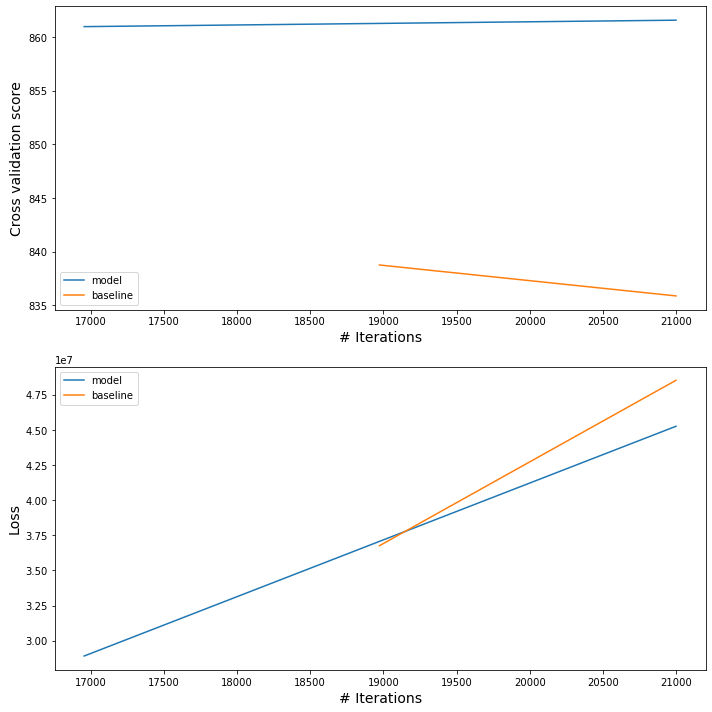

In [15]:
!mkdir -p songbird

#Set up dictionaries
#factor_dict = {"t1d":"analysis_t1d", "weight":"analysis_weight_group", "null":"1" }
songbird_dict={}
songbird_dict["both"] = {}
songbird_dict["null"] = {}
tensor_dict = {}
#Run/Import Songbird
factor="both"
folder = "songbird/" +  factor
if not os.path.exists(folder):
    !mkdir -p $folder
    #Calculate Songbird
    (temp_differentials,
     temp_regression_stats,
     temp_regression_biplot) = multinomial(table=b2q(bt_genus),
                                           metadata=qza_md,
                                           formula="analysis_t1d + analysis_weight_group")
    (null_differentials,
     null_regression_stats,
     null_regression_biplot) = multinomial(table=b2q(bt_genus),
                                           metadata=qza_md,
                                           formula="1")
    
    #Add outputs to master dictionary
    songbird_dict[factor]["differentials"] = temp_differentials
    songbird_dict[factor]["regression_stats"] = temp_regression_stats
    songbird_dict[factor]["regression_biplot"] = temp_regression_biplot
    songbird_dict["null"]["differentials"] = null_differentials
    songbird_dict["null"]["regression_stats"] = null_regression_stats
    songbird_dict["null"]["regression_biplot"] = null_regression_biplot
    #Check model fit
    tensor_dict[factor] = summarize_paired(regression_stats = songbird_dict[factor]["regression_stats"],
                                                       baseline_stats = songbird_dict["null"]["regression_stats"]).visualization
    tensor_dict[factor].save(folder + "/model_fit_stats.qzv")
    #Save outputs
    temp_differentials.save(folder + "/differentials.qza")
    temp_regression_stats.save(folder + "/regression_stats.qza")
    temp_regression_biplot.save(folder + "/regression_biplot.qza")
else:
    songbird_dict[factor]["differentials"] = q2.Artifact.load(folder + "/differentials.qza")
    songbird_dict[factor]["regression_stats"] = q2.Artifact.load(folder + "/regression_stats.qza")
    songbird_dict[factor]["regression_biplot"] = q2.Artifact.load(folder + "/regression_biplot.qza")

In [16]:
pwd

'/projects/cmi_proj/seed_grants/T1D_JaneKim/shotgun'

## Check model fit

Negative Q2 scores on both T1D and Weight and for both

t1d
weight


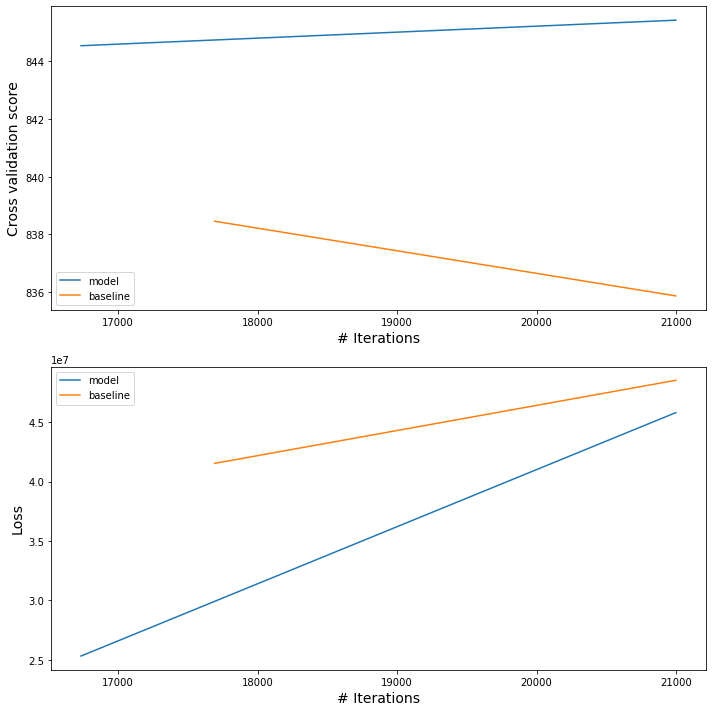

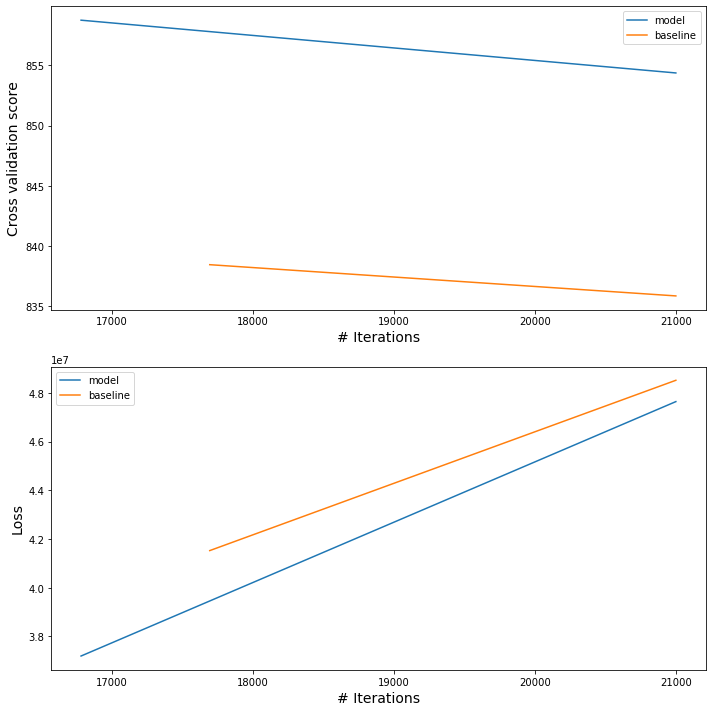

In [188]:
tensor_dict = {}
for factor in ["t1d","weight"]:
    folder = "songbird/" + factor
    print(factor)
    tensor_dict[factor] = summarize_paired(regression_stats = songbird_dict[factor]["regression_stats"],
                                                       baseline_stats = songbird_dict["null"]["regression_stats"]).visualization
    #Save output
    tensor_dict[factor].save(folder + "/model_fit_stats.qzv")

## Log ratio Bacteroides / E. coli

F_onewayResult(statistic=0.43403945846670905, pvalue=0.7290552401842418)


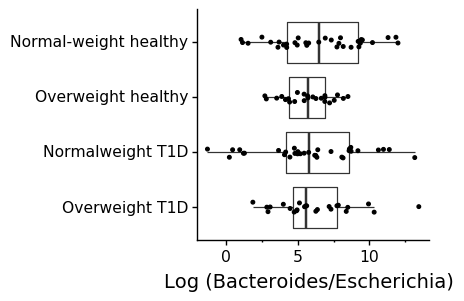

<ggplot: (8742805279422)>

In [60]:
numerator=['k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides']
denom = ['k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacterales; f__Enterobacteriaceae; g__Escherichia']
bac = numerator +denom
bt_filt = bt_genus.filter(bac, inplace=False, axis=o)
df_filt = pd.DataFrame(bt_filt.to_dataframe())
#Add pseudocount
df_filt = df_filt+1


ratio_df = pd.DataFrame(df_filt.apply(axis=0, func=lambda row:log(row[0]/(row[1]))), columns=["ratio"])\
    .merge(md.loc[:,["analysis_t1d", "analysis_weight_group","analysis_disease_stage_group","host_body_mass_index_z_score"]], right_index=True, left_index=True)
ratio_df = ratio_df.loc[np.isfinite(ratio_df.ratio)]

#Run anova and make boxplot
make_boxplot(ratio_df, "analysis_disease_stage_group", "ratio","Log (Bacteroides/Escherichia)")


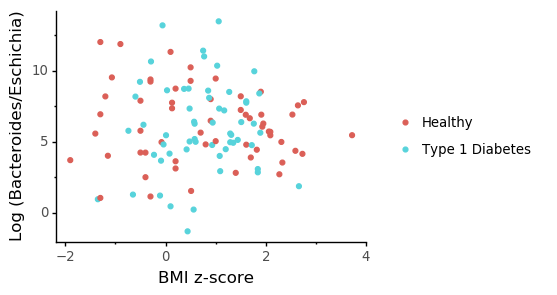

<ggplot: (8742807515831)>

In [15]:
pn.options.figure_size = (4,3)
p = (pn.ggplot(data=ratio_df) +
     pn.geom_point( pn.aes(x="host_body_mass_index_z_score", y="ratio", color="analysis_t1d")) +
     pn.labs( x="BMI z-score", y="Log (Bacteroides/Eschichia)", color='') +
     pn.theme_classic(base_size=12)
    )
p

### Log ratio Bifido/Bacteroides

F_onewayResult(statistic=4.719499816405322, pvalue=0.0038859132546299963)


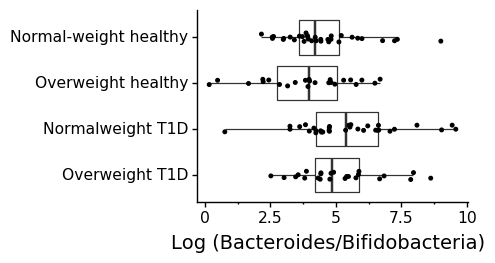

<ggplot: (-9223363294049334093)>

In [58]:
numerator=['k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides']
denom = ['k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Bifidobacteriales; f__Bifidobacteriaceae; g__Bifidobacterium']
bac = numerator +denom
bt_filt = bt_genus.filter(bac, inplace=False, axis=o)
df_filt = pd.DataFrame(bt_filt.to_dataframe())

#Add pseudocount
df_filt = df_filt+1

ratio_df = pd.DataFrame(df_filt.apply(axis=0, func=lambda row:log(row[0]/(row[1]))), columns=["ratio"])\
    .merge(md.loc[:,["analysis_t1d", "analysis_weight_group","analysis_disease_stage_group","host_body_mass_index_z_score"]], right_index=True, left_index=True)
ratio_df = ratio_df.loc[np.isfinite(ratio_df.ratio)]

p = make_boxplot(ratio_df, "analysis_disease_stage_group", "ratio","Log (Bacteroides/Bifidobacteria)")

pn.options.figure_size= (3,3)
p

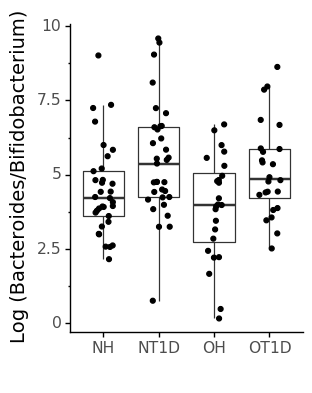

<ggplot: (-9223363294047223054)>

In [20]:
pn.options.figure_size = (3,4)
p = (pn.ggplot(data=ratio_df) +
    pn.geom_boxplot( pn.aes(x="analysis_disease_stage_group", y="ratio"), outlier_alpha=0) +
     pn.geom_jitter( pn.aes(x="analysis_disease_stage_group", y="ratio"), width=.2) +
     pn.labs( x=" ", y="Log (Bacteroides/Bifidobacterium)") +
     pn.theme_classic(base_size=14)
    )
p

In [22]:
grps = set(ratio_df.analysis_disease_stage_group)
anova_values = [list(ratio_df.query('analysis_disease_stage_group==@x').ratio) for x in grps]
f_oneway(*anova_values)

F_onewayResult(statistic=4.719499816405322, pvalue=0.0038859132546299963)

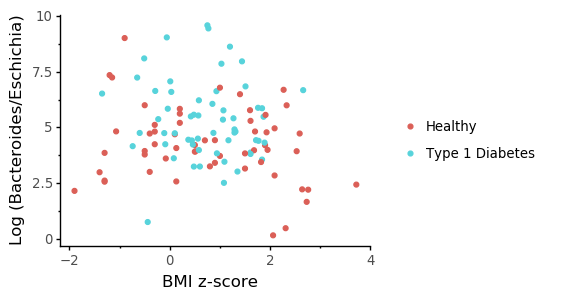

<ggplot: (8742807539029)>

In [23]:
pn.options.figure_size = (4,3)
p = (pn.ggplot(data=ratio_df) +
     pn.geom_point( pn.aes(x="host_body_mass_index_z_score", y="ratio", color="analysis_t1d")) +
     pn.labs( x="BMI z-score", y="Log (Bacteroides/Eschichia)", color='') +
     pn.theme_classic(base_size=12)
    )
p